# SLT-CE-3: Deterministic Annealing

<h2 style="background-color:#f0b375;"> References </h2>

<ol>
<li> Deterministic annealing for clustering, compression, classification, regression, and related optimization
problems, Kenneth Rose, 1998, http://ieeexplore.ieee.org/document/726788/
</li>
    
<li>
A Ratio Scale Metric and the Compatibility
of Ratio Scales: The Possibility of
Arrow’s Impossibility Theorem, T.L. Saalty, 1994, https://www.sciencedirect.com/science/article/pii/0893965994900930
</li>

<li>
The wine data set, http://www3.dsi.uminho.pt/pcortez/wine5.pdf
</li>
    
<li>
Lecture 3, slide 19, https://ml2.inf.ethz.ch/courses/slt/lectures/slt18_lecture03.pdf
</li>
    
</ol>

<h2 style="background-color:#f0b375;"> Setup </h2>

Note: During the preprocessing part I have removed nonpositive data so that there would not be any division by zero error in ratioscale part.

In [1]:
import sklearn as skl
import sklearn.model_selection
import sklearn.cluster
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# For ratioscale fit method
import tensorflow as tf; tf.enable_eager_execution()
import scipy as sp

# Make sure to install treelib in the slt-ce conda environment: conda install treelib
import treelib as tl

from sklearn.utils.validation import check_is_fitted

<h2 style="background-color:#f0b375;">
Section Preliminary
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 0.0 </span>
</h2>

<p style="background-color:#adebad;">
    Implement the function read_X_y_from_csv according to the contract in its docstring.
</p>

In [2]:
def read_X_y_from_csv(sheet, y_names=None):
    """Parse a column data store into X, y arrays

    Args:
        sheet (str): Path to csv data sheet.
        y_names (list of str): List of column names used as labels.

    Returns:
        X (np.ndarray): Array with feature values from columns that are not contained in y_names (n_samples, n_features)
        y (dict of np.ndarray): Dictionary with keys y_names, each key contains an array (n_samples, 1)
                                with the label data from the corresponding column in sheet. 
    """

    # Your code goes here
    X = pd.read_csv(sheet, header=0)
    X = X[(X > 0).all(1)].reset_index()
    y = X[y_names].copy()
    X = X.drop(y_names, axis=1)
    X = X.drop('index', axis=1)
    return X.values, y.to_dict()

<p style="background-color:#adebad;">
Read the wine data [3], which contains 11 physiochemical attributes, and two labels (quality and color).
</p>

In [3]:
X, y = read_X_y_from_csv("wine-data.csv", y_names=["quality", "color"])

<h2 style="background-color:#f0b375;">
Section 4.0
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.0 </span>
</h2>

<p style="background-color:#adebad;">
    Read reference [1] about deterministic annealing clustering (DAC). Shortly summarize what they refer to as the <i>preferred implementation</i> of the DAC algorithm.
</p>

Put your markdown text here

1. Initialise $T$ large.
2. For $i = 1$ to $K$, update

    $$ y_k = \frac{\sum_i x_i p(x_i) \frac{\exp\left(-(x_i-y_k)^2 / T\right)}{\sum_k \exp\left(-(x_i-y_k)^2 / T\right)}}{ \sum_i p(x_i) \frac{\exp\left(-(x_i-y_k)^2 / T\right)}{\sum_k \exp\left(-(x_i-y_k)^2 / T\right)} } $$
    
    using an iterative update approach.

3. Stop if $T$ is small.
4. $T \gets \alpha T$, $\alpha < 1$. Go back to (3).

<p style="background-color:#adebad;">
    Implement the <b>fit method</b> for the template class DeterministicAnnealing, according to the contract outlined in its docstring.
    You can add more class methods as necessary.
    See http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html for complementary information.
</p>

In [4]:
class DeterministicAnnealingClustering(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for DAC
    
    Attributes:
        cluster_centers_ (np.ndarray): Cluster centroids y_i (n_clusters, n_features)
        cluster_probabs_ (np.ndarray): Assignment probability vectors p(y_i | x) for each sample
                                       (n_samples, n_clusters)
        bifurcation_tree_ (treelib.Tree): Tree object that contains information about cluster evolution during
                                          annealing.
                                       
    Parameters:
        n_clusters (int): Maximum number of clusters returned by DAC.
        random_state (int): Random seed.
    """
    
    def __init__(self, n_clusters=8, random_state=42, metric="euclidian", t_decay=0.9):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.metric = metric
        # Add more parameters, if necessary.
        self.t_decay = t_decay
        self.distortions = []
        self.n_eff_clusters = []
        self.temp = []
    
    def fit(self, X):
        """Compute DAC for input vectors X
        
        Preferred implementation of DAC as described in reference [1].
        Consider to use initialization and reseeding as in sklearn k-means for improved performance.
        
        Args:
            X (np.ndarray): Input array with shape (samples, n_features)
        
        Returns:
            self
        """
        
        if self.metric == "euclidian":
            # Your code goes here
            temperature = 1e5
            
            self.cluster_centers_ = np.zeros([self.n_clusters, X.shape[1]])
            self.cluster_centers_ += np.average(X, axis=0) # by broadcasting
            self.cluster_centers_ += np.random.normal(scale=1, size=self.cluster_centers_.shape) # add perturbations to centroids
            
            norm_diffs = np.linalg.norm(X[:, np.newaxis, :] - self.cluster_centers_[np.newaxis, :, :], axis=-1)
            self.cluster_probabs_ = np.exp(-norm_diffs / temperature) / self.n_clusters # T -> inf => p(y_i) = 1/K
            self.cluster_probabs_ /= np.sum(self.cluster_probabs_, axis=1)[:, np.newaxis]
            
            pre_eff_clusters = 1
            self.bifurcation_tree_ = tl.Tree()
            self.bifurcation_tree_.create_node(0, 0, data=[self.cluster_centers_[0], 0])
            
            while temperature > .5:
                prob_y = np.sum(self.cluster_probabs_ / X.shape[0], axis=0)
                norm_diffs = np.linalg.norm(X[:, np.newaxis, :] - self.cluster_centers_[np.newaxis, :, :], axis=-1)
                self.cluster_probabs_ = np.exp(-norm_diffs / temperature) * prob_y
                self.cluster_probabs_ /= np.sum(self.cluster_probabs_, axis=1)[:, np.newaxis]
                
                self.cluster_centers_ = self.cluster_probabs_.T.dot(X) / X.shape[0]
                self.cluster_centers_ /= np.sum(self.cluster_probabs_ / X.shape[0], axis=0)[:, np.newaxis]
                
                Y = np.linalg.norm(X[:, np.newaxis, :] - self.cluster_centers_[np.newaxis, :, :], axis=-1)
                dist = np.mean(np.amin(Y, axis=1))
                
                self.distortions.append(dist)
                eff_clusters_idx = ~(np.triu(np.linalg.norm(self.cluster_centers_[:, np.newaxis, :] - self.cluster_centers_[np.newaxis, :, :], axis=-1) <= 10, 1)).any(0)
                eff_clusters = np.count_nonzero(eff_clusters_idx)
                eff_clusters_idx = np.where(eff_clusters_idx != 0)[0]
                if eff_clusters != pre_eff_clusters:
                    eff_clusters_pos = self.cluster_centers_[eff_clusters_idx]
                    names = list(map(lambda n: n.identifier, self.bifurcation_tree_.leaves()))
                    leaves = np.array(list(map(lambda n: n.data[0], self.bifurcation_tree_.leaves())))
                    norms = np.linalg.norm(leaves[:, None, :] - eff_clusters_pos[None, :, :], axis=-1)
                    to_idx = np.argmin(norms, axis=0)
                    for idx, pos in enumerate(eff_clusters_idx):
                        self.bifurcation_tree_.create_node(len(self.bifurcation_tree_), len(self.bifurcation_tree_),
                                                          parent=names[to_idx[idx]], data=[self.cluster_centers_[pos], norms[to_idx[idx], idx]])
                        
                else:
                    eff_clusters_pos = self.cluster_centers_[eff_clusters_idx]
                    names = list(map(lambda n: n.identifier, self.bifurcation_tree_.leaves()))
                    leaves = np.array(list(map(lambda n: n.data[0], self.bifurcation_tree_.leaves())))
                    norms = np.linalg.norm(leaves[:, None, :] - eff_clusters_pos[None, :, :], axis=-1)
                    to_idx = np.argmin(norms, axis=0)
                    for idx, pos in enumerate(eff_clusters_idx):
                        self.bifurcation_tree_.update_node(names[to_idx[idx]], data=[self.cluster_centers_[pos], norms[to_idx[idx], idx]])

                self.n_eff_clusters.append(eff_clusters)
                pre_eff_clusters = eff_clusters
                self.temp.append(temperature)
                
                temperature = self.t_decay * temperature
                    
                                            
        elif self.metric == "ratioscale":
            
            # code for extension
            temperature = tf.Variable(1e3, dtype=tf.float64)
            
            self.cluster_centers_ = np.zeros([self.n_clusters, X.shape[1]])
            self.cluster_centers_ += np.average(X, axis=0) # by broadcasting
            self.cluster_centers_ += np.random.normal(scale=1e-1, size=self.cluster_centers_.shape) # add perturbations to centroids
            self.cluster_centers_ = np.clip(self.cluster_centers_, 1e-6, np.inf)
            norm_diffs = np.linalg.norm(X[:, np.newaxis, :] - self.cluster_centers_[np.newaxis, :, :], axis=-1)
            self.cluster_centers_ = tf.contrib.eager.Variable(self.cluster_centers_)
            
            self.cluster_probabs_ = np.exp(-norm_diffs / 1e5) / self.n_clusters # T -> inf => p(y_i) = 1/K
            self.cluster_probabs_ /= np.sum(self.cluster_probabs_, axis=1)[:, np.newaxis]
            
            self.cluster_probabs_ += np.random.normal(scale=1e-3, size=self.cluster_probabs_.shape) # add perturbations to centroids
            self.cluster_probabs_ = tf.contrib.eager.Variable(self.cluster_probabs_, constraint=tf.nn.softmax)
            self.cluster_probabs_.assign(tf.nn.softmax(self.cluster_probabs_))
            
            t_decay = tf.constant(self.t_decay, dtype=tf.float64)
            
            opt_p = tf.train.AdamOptimizer(learning_rate=3)
            opt_c = tf.train.AdamOptimizer(learning_rate=1e-3)
            
            while temperature > .5:
                for epoch in range(5):
    
                    with tf.GradientTape() as tape:
                        tape.watch(self.cluster_probabs_)
                        
                        c = (X[:, :, None] / X[:, None, :])[:, None] / (self.cluster_centers_[:, :, None] / self.cluster_centers_[:, None, :])
                        c = tf.reduce_sum(c, axis=(-1, -2))
                        c = tf.log(c / X.shape[1] ** 2)
                        probs = tf.reduce_sum(self.cluster_probabs_ / X.shape[0], axis=0)
                        c = tf.reduce_sum(c * self.cluster_probabs_)
                        loss = -(tf.reduce_sum(probs * tf.log(probs)) - 1/temperature * c) + \
                                tf.reduce_sum(probs)
                        
                    grads = tape.gradient(loss, [self.cluster_probabs_])
                    opt_p.apply_gradients(zip(grads, [self.cluster_probabs_]))

                for epoch in range(10):
                    with tf.GradientTape() as tape:
                        tape.watch(self.cluster_centers_)

                        c = (X[:, :, None] / X[:, None, :])[:, None] / (self.cluster_centers_[:, :, None] / self.cluster_centers_[:, None, :])
                        c = tf.reduce_sum(c, axis=(-1, -2))
                        c = tf.log(c / X.shape[1] ** 2)
                        probs = tf.reduce_sum(self.cluster_probabs_ / X.shape[0], axis=0)

                        c = tf.reduce_sum(c * self.cluster_probabs_)

                        loss = -(tf.reduce_sum(probs * tf.log(probs)) - 1/temperature * c)

                    grads = tape.gradient(loss, [self.cluster_centers_])
                    opt_c.apply_gradients(zip(grads, [self.cluster_centers_]))
                    
                temperature = temperature * t_decay
        
        return self
    
    def predict(self, X):
        """Predict assignment probability vectors for each sample in X.
        
        Args:
            X (np.ndarray): Input array with shape (new_samples, n_features)
            
        Returns:
            P (np.ndarray): Assignment probability vectors (new_samples, n_clusters) 
        """
        
        # Your code goes here
        
        temperature = 1e5

        norm_diffs = np.linalg.norm(X[:, np.newaxis, :] - self.cluster_centers_[np.newaxis, :, :], axis=-1)
        P = np.exp(-norm_diffs / temperature) / self.n_clusters # T -> inf => p(y_i) = 1/K
        P /= np.sum(P, axis=1)[:, np.newaxis]

        while temperature > .5:
            prob_y = np.sum(P / X.shape[0], axis=0)
            norm_diffs = np.linalg.norm(X[:, np.newaxis, :] - self.cluster_centers_[np.newaxis, :, :], axis=-1)
            P = np.exp(-norm_diffs / temperature) * prob_y
            P /= np.sum(P, axis=1)[:, np.newaxis]

            temperature = self.t_decay * temperature
        
        
        return P
    
    def transform(self, X):
        """Transform X to a cluster-distance space.
        
        In the new space, each dimension is the distance to the cluster centers. 
        
        Args:
            X (np.ndarray): Input array with shape (new_samples, n_features)
            
        Returns:
            Y (np.ndarray): Cluster-distance vectors (new_samples, n_clusters)
        """
        check_is_fitted(self, ["cluster_centers_"])
        
        # Your code goes here
        Y = np.linalg.norm(X[:, np.newaxis, :] - self.cluster_centers_[np.newaxis, :, :], axis=-1)
        
        return Y
    
    def plot_bifurcation(self):
        """Show the evolution of cluster splitting"""
        check_is_fitted(self, ["bifurcation_tree_"])
        
        # Your code goes here
        
        return None
        

<p style="background-color:#adebad;">
    Create an instance of your DAC class with n_clusters = 2 and <b>fit the first 6000 samples</b> of the wine data set. Record the execution time. Furthermore, create an instance of the sklearn k-means class, and fit it with the same parameters. Again record the execution time.
</p>

In [6]:
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(X,
                                                                        y["color"],
                                                                        train_size=6000,
                                                                        random_state=42)

/home/mcreng/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [7]:
%%time
import sys
np.set_printoptions(threshold=sys.maxsize)
DAC = DeterministicAnnealingClustering(n_clusters=2, random_state=42)
DAC.fit(X_train)

CPU times: user 280 ms, sys: 3.3 ms, total: 284 ms
Wall time: 283 ms


In [8]:
%%time
kmeans = skl.cluster.KMeans(n_clusters=2,random_state=42)
kmeans.fit(X_train)

CPU times: user 279 ms, sys: 321 ms, total: 601 ms
Wall time: 246 ms


In [9]:
print(DAC.cluster_centers_)
print(kmeans.cluster_centers_)

[[6.91384297e+00 2.86951692e-01 3.40856614e-01 7.34440577e+00
  4.88724746e-02 4.01188686e+01 1.56835209e+02 9.94859656e-01
  3.18930522e+00 5.00588684e-01 1.02356341e+01]
 [7.64011358e+00 3.91415462e-01 3.06981008e-01 3.15050209e+00
  6.46070618e-02 1.87018050e+01 6.61846372e+01 9.94476179e-01
  3.24356921e+00 5.67786120e-01 1.08070367e+01]]
[[6.91301836e+00 2.86863152e-01 3.40879739e-01 7.35313981e+00
  4.88933649e-02 4.01411434e+01 1.56873371e+02 9.94863235e-01
  3.18927429e+00 5.00459123e-01 1.02339544e+01]
 [7.64035823e+00 3.91411966e-01 3.06989329e-01 3.14397866e+00
  6.45625000e-02 1.86972180e+01 6.62374238e+01 9.94472006e-01
  3.24354802e+00 5.67877287e-01 1.08085556e+01]]


<h2 style="background-color:#f0b375;">
Section 4.5
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
    <ul style="background-color:#adebad;">
        <li> Implement the <b>predict method</b> for the template class DAC, according to the contract outlined in its docstring.
        </li>
        
        <li>
            Use DAC.predict and kmeans.predict to predict the cluster labels of X_test.
        </li>
        
        <li>
            Compute the confusion matrix between the two predictions as described in <br>
            http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
        </li>
    </ul>
</p>

In [10]:
%%time
y_kmeans = kmeans.predict(X_test)

CPU times: user 0 ns, sys: 3.37 ms, total: 3.37 ms
Wall time: 1.88 ms


In [11]:
%%time
y_DAC = DAC.predict(X_test)

CPU times: user 49.6 ms, sys: 25.7 ms, total: 75.3 ms
Wall time: 33.5 ms


<ul style="background-color:#adebad;">
<li> Before we can compute the confusion matrix, we need to perform some post-processing on the DAC cluster assignments.
    Explain what the function postprocess (defined below) does, and why we need it. To do so, complete the docstring of the function postprocess.
        </li>
</ul>

In [12]:
def postprocess(y_DAC, y_kmeans):
    """This function maps the cluster centroid order in DAC.cluster_centers_ to the 
    order in kmeans.cluster_centers. 
    
    It is done by identifying the data point with the highest probability to be 
    classified to each cluster in DAC, and find the index of that data point in kmeans.
    Then, all indicies in y_DAC_hard is converted accordingly.
    
    We need this function since we wish to compare the performance of two clustering,
    but doing so we require knowing the order of the cluster centroids otherwise we 
    could not compare.
    
    Arguments:
        y_DAC (np.ndarray): Probabilities of each data point being assigned to each 
        centroid. (new_samples, n_centroids)
        y_kmeans (np.ndarray): Indicies of centroid each data point is mapped to by 
        kmeans. (new_samples, )
        
    Returns:
        np.ndarray: Indicies of centroid each data point is mapped to by DAC, aligned
        with the order in kmeans. (new_samples, )
    """
    
    y_DAC_hard = np.argmax(y_DAC, axis=1)
    
    n_clusters = len(np.unique(y_DAC_hard))
    dac2kmeans = []
    for cluster in range(n_clusters):
        argmax = np.argmax(y_DAC[:, cluster])
        dac2kmeans.append(y_kmeans[argmax])
    
    y_DAC_new = []
    for dac_label in y_DAC_hard:
        y_DAC_new.append(dac2kmeans[dac_label])
        
    return np.array(y_DAC_new)

In [13]:
sklearn.metrics.confusion_matrix(y_kmeans, postprocess(y_DAC, y_kmeans))

array([[205,   0],
       [  0, 136]])

<h2 style="background-color:#f0b375;">
Section 5.0
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.0 </span>
</h2>

<ul style="background-color:#adebad;">
        <li> Implement the <b>transform method</b> for the template class DAC, according to the contract outlined in its docstring.
        </li>
        <li>
        Use DAC.transform and kmeans.transform to transform both, X_train and X_test. 
        </li>
       
</ul>

In [14]:
X_train_DAC = DAC.transform(X_train)
X_test_DAC = DAC.transform(X_test)

X_train_kmeans = kmeans.transform(X_train)
X_test_kmeans = kmeans.transform(X_test)

<ul style="background-color:#adebad;">
        <li>
        Fit an SVM classifier with default parameters to the untransformed data, and to the transformed data.
        Compare the performance of predicting whether the color of a wine is red or white.
        </li>
    </ul>

In [15]:
svm = skl.svm.SVC(random_state=42)
svm.fit(X_train, y_train)
svm.score(X_test, y_test)

0.9501466275659824

In [16]:
svm_DAC = skl.svm.SVC(random_state=42)
svm_DAC.fit(X_train_DAC, y_train)
svm_DAC.score(X_test_DAC, y_test)

0.9384164222873901

In [17]:
svm = skl.svm.SVC(random_state=42)
svm.fit(X_train_kmeans, y_train)
svm.score(X_test_kmeans, y_test)

0.9384164222873901

<ul style="background-color:#adebad;">
        <li>
        Produce two scatter plots, one for X_train_DAC and one for X_train_kmeans.<br>
        Make the marker color indicate the wine color.
        </li>
    </ul>

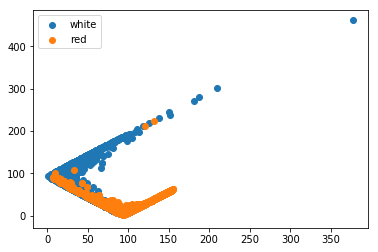

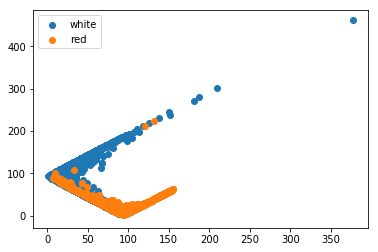

In [18]:
plt.figure()
plt.scatter(X_train_DAC[np.where(np.array(y_train)=='white'), 0], X_train_DAC[np.where(np.array(y_train)=='white'), 1], label='white')
plt.scatter(X_train_DAC[np.where(np.array(y_train)=='red'), 0], X_train_DAC[np.where(np.array(y_train)=='red'), 1], label='red')
plt.legend()
plt.figure()
plt.scatter(X_train_kmeans[np.where(np.array(y_train)=='white'), 0], X_train_kmeans[np.where(np.array(y_train)=='white'), 1], label='white')
plt.scatter(X_train_kmeans[np.where(np.array(y_train)=='red'), 0], X_train_kmeans[np.where(np.array(y_train)=='red'), 1], label='red')
plt.legend()
plt.show()

<h2 style="background-color:#f0b375;">
Section 5.5
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>
<ul style="background-color:#adebad;">
        <li>
            Fit and transform X_train with DAC(n_clusters=3,4,5,6,7,8,...). Produce a plot of the SVM score svm_DAC.score(X_test_DAC, y_test) as a function of n_clusters.
        </li>
    </ul>
</p>

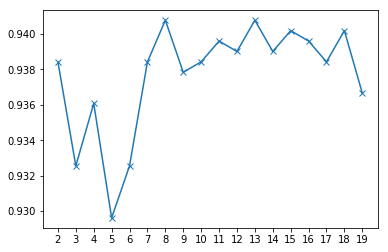

In [19]:
scores = []
for cluster in range(2, 20):
    average = 0
    for _ in range(5):
        DAC = DeterministicAnnealingClustering(n_clusters=cluster, random_state=42)
        DAC.fit(X_train)
        X_train_DAC = DAC.transform(X_train)
        X_test_DAC = DAC.transform(X_test)
        svm_DAC = skl.svm.SVC(random_state=42)
        svm_DAC.fit(X_train_DAC, y_train)
        average += svm_DAC.score(X_test_DAC, y_test)
    scores.append(average / 5)
    
plt.xticks(list(range(2, 20)))
plt.plot(list(range(2, 20)), scores, 'x-')
plt.show()

<ul style="background-color:#adebad;">
        <li>
            Produce a phase diagram plot of the expected distortion D, as shown in figure 2 of reference [1]. For this, extend DAC.fit to save the expected distortion during annealing as an additional attribute self.distortion.
            You might also want to save the number of effective clusters and the temperature along the way.
        </li>
    </ul>
</p>

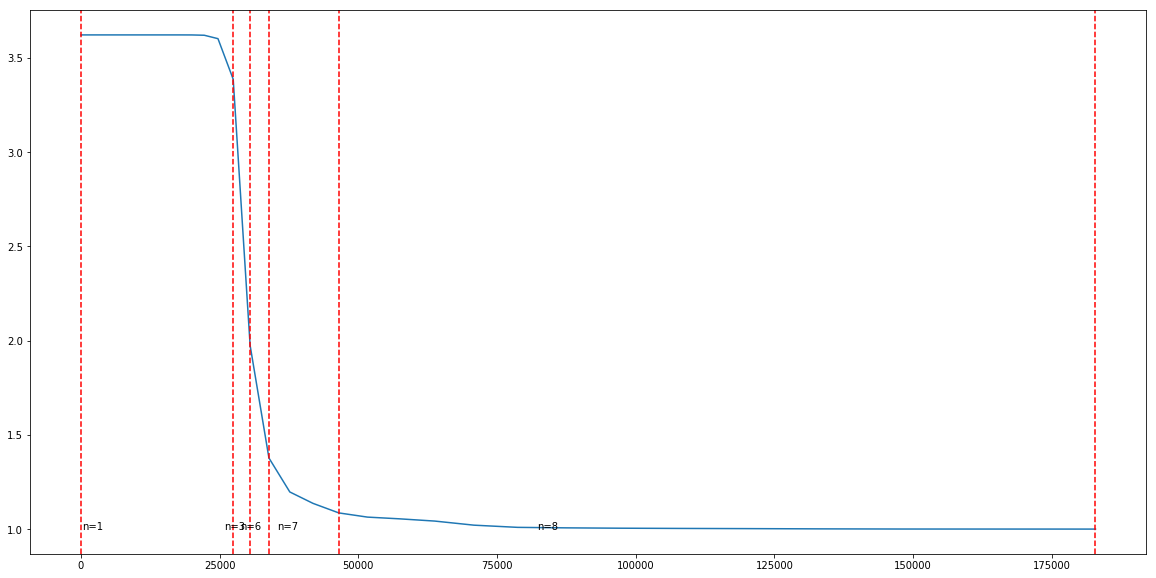

In [20]:
# extend DAC.fit(self, X):
    # ...
    # Save information for each (n-th) annealing step:
    # self.distortion = [d0, d1, d2, ...]
    # self.n_eff_clusters = [e0, e1, e2, ...]
    # self.temp = [t0, t1, t2, ...]
    # ...
DAC = DeterministicAnnealingClustering()
DAC.fit(X_train)

d = np.array(DAC.distortions)
d /= np.min(d)
t = 1 / np.array(DAC.temp)
t /= np.min(t)
plt.figure(figsize=(20, 10))
plt.plot(t, d)

n = np.array(DAC.n_eff_clusters)
idx = np.insert(np.nonzero(np.diff(n))[0] + 1, 0, 0)
idx = np.insert(idx, len(idx), len(n)-1)

for _ in t[idx]:
    plt.axvline(_, color='r', linestyle='--')

loc = 10 ** ((np.log10(t[idx[:-1]]) + np.log10(t[idx[1:]])) / 2 - 0.05)
anno = n[(np.nonzero(np.diff(n))[0] + 1)]
anno = np.insert(anno, 0, 1)
for (l, a) in zip(loc, anno):
    plt.text(l, 1, 'n={}'.format(a))
    
plt.show()

<ul style="background-color:#adebad;">
        <li>
            So far, our implementation of DAC assumed that our data is compatible with the euclidian metric. Argue why this assumption is not justified for the wine-data.
        </li>
    </ul>
</p>

Let's say for a property A, given three wines of value 1, 10, 20. Using Euclidean metric, we are assuming the data is additive in nature, i.e. second wine has a less improvement to the first one ($10-1=9$, comparing to the third to the second ($20-10=10$). However, if the values are in ratio, then the data has a multiplicative nature. So, the second wine would actually have a larger improvement to the first one ($10/1=10$), comparing to the third to the second ($20/10=2$). Using the Euclidean metric does not capture such property.

<ul style="background-color:#adebad;">
        <li>
        All the features of the wine-data set are measured on a ratio scale, which is incompatible with the euclidian metric (Remark: this is not the complete answer to problem 6, argue why they are not compatible). A more appropriate distance is proposed in reference [2]:
            <br><br>
            $d(x,y)=\log{ \frac{1}{d^2} \sum_{i,j=1}^d \frac{x_i}{x_j} \frac{y_j}{y_i}}$
            <br><br>
            Extend DAC.fit to the case of metric == ratioscale, using d(x,y) as given above.<br>
            Hint: As this distance does not give a closed form update formula for the centroids $y$, you will need to do gradient descent to update the centroids. You can either calculate the gradient by hand, or use an automatic differentiation tool like Tensorflow. If you calculate the gradient by hand, provide the formula in Latex below.
        </li>
        <li>
        Perform experiments to compare the euclidian and ratioscale metrics.
    </li>
</ul>


In [23]:
scores_r = []
for cluster in [2, 5, 8, 10, 15, 20]:
    DAC = DeterministicAnnealingClustering(n_clusters=cluster, random_state=42, metric='ratioscale')
    DAC.fit(X_train)
    X_train_DAC = DAC.transform(X_train)
    X_test_DAC = DAC.transform(X_test)
    svm_DAC = skl.svm.SVC(random_state=42)
    svm_DAC.fit(X_train_DAC, y_train)
    scores_r.append(svm_DAC.score(X_test_DAC, y_test))
    

Using ratioscale is consistently better.

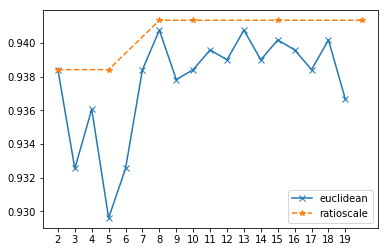

In [26]:
plt.xticks(list(range(2, 20)))
plt.plot(list(range(2, 20)), scores, 'x-', label='euclidean')
plt.plot([2, 5, 8, 10, 15, 20], scores_r, '*--', label='ratioscale')
plt.legend()
plt.show()

<h2 style="background-color:#f0b375;">
Section 6.0
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<ul style="background-color:#adebad;">
        <li>
        Implement DAC.plot_bifurcation, which should create a bifurcation plot as shown on slide 19 of lecture 3. As our data is not 1-dimensional as in the lecture slide, we will have to adapt our scheme, so that the distances between nodes of the tree make sense.<br>
        Modify DAC.fit to keep track of the distances, using the tree object DAC.bifurcation\_tree\_. When a cluster splits, it creates two child nodes. Each node should store its centroid vector, and the distance to the parent centroid vector. After splitting, the parent node is not updated anymore.<br>
        In the bifurcation plot, the horizontal distance of a child node to its parent node should be exactly the distance to the parent centroid vector. The two child nodes should move in opposite directions, i.e. one to the left of the parent and one to the right.
        </li>
    </ul>

In [167]:
DAC = DeterministicAnnealingClustering(n_clusters=5, random_state=42, t_decay=0.99)
DAC.fit(X_train)

DeterministicAnnealingClustering(metric='euclidian', n_clusters=5,
                 random_state=42, t_decay=0.99)

In [168]:
DAC.bifurcation_tree_.show()

0
├── 1
│   └── 3
│       └── 6
│           └── 10
└── 2
    ├── 4
    │   └── 7
    │       ├── 11
    │       └── 13
    └── 5
        ├── 8
        │   └── 12
        └── 9
            └── 14



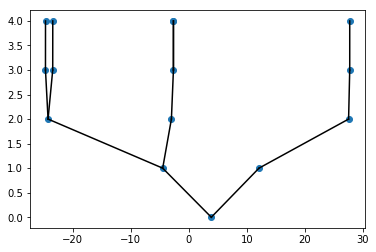

In [181]:
l = list(map(lambda n: [n.identifier, DAC.bifurcation_tree_.parent(n.identifier).identifier if DAC.bifurcation_tree_.parent(n.identifier) else None, 
                    DAC.bifurcation_tree_.depth(n), n.data[1]], DAC.bifurcation_tree_.all_nodes()))

parents = [0] * len(l)

for node in l:
    if node[1] is not None:
        if parents[node[1]] == 0:
            sign = 1
        elif parents[node[1]] == 1:
            sign = -1
            
        parents[node[1]] += 1
        
        node[3] = l[node[1]][3] + sign * node[3]
        
        
l = np.array(l)[:, (-2, -1, -3)]

plt.scatter(l[:, 1], l[:, 0])

for node in l:
    if node[2] is not None:
        plt.plot([node[1], l[node[2]][1]], [node[0], l[node[2]][0]], 'k-')


plt.show()


<ul style="background-color:#adebad;">
        <li>
        Argue how reasonable our method of plotting the bifurcation is. Explain how the 1D-distances between nodes (i.e. nodes that are not siblings) do not correspond exactly to the distances between centroids. Suggest ideas for improvement.
        </li>
    </ul>

It is a good estimate but it does not reflect exactly the distances. This is because of the triangle inequality. If we have three nodes A, B, C, even if we know the distance between AB and AC, we still do not know the exact distance of BC, which means the plot may not reflect that properly.

<ul style="background-color:#adebad;">
    <li>
        First create a fixed 2D embedding (e.g. with LLE, t-SNE, MDS) of the wine data and color the markers according to quality and color. Then run the DAC algorithm on the wine-data set for different n_clusters. Each time use marker shapes to display the cluster memberships, and compare to the labels color and quality.
    </li>
</ul>

In [5]:
X_train_q, _, y_train_q, _ = skl.model_selection.train_test_split(X,
                                                                        y["quality"],
                                                                        train_size=6000,
                                                                        random_state=42)
X_train_c, _, y_train_c, _ = skl.model_selection.train_test_split(X,
                                                                        y["color"],
                                                                        train_size=6000,
                                                                        random_state=42)

/home/mcreng/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [6]:
tsne_q = skl.manifold.TSNE()
embed_q = tsne_q.fit_transform(X_train_q, y_train_q)
tsne_c = skl.manifold.TSNE()
embed_c = tsne_c.fit_transform(X_train_c, y_train_c)

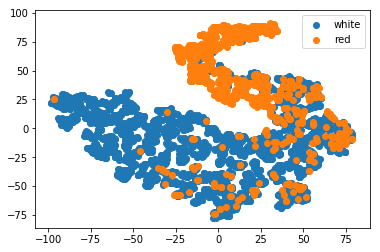

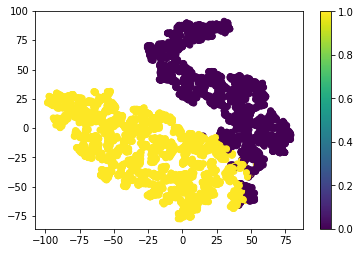

In [9]:
plt.figure()
plt.scatter(embed_c[np.where(np.array(y_train_c)=='white'), 0], embed_c[np.where(np.array(y_train_c)=='white'), 1], label='white')
plt.scatter(embed_c[np.where(np.array(y_train_c)=='red'), 0], embed_c[np.where(np.array(y_train_c)=='red'), 1], label='red')
plt.legend()

DAC = DeterministicAnnealingClustering(n_clusters=2, random_state=42)
DAC.fit(X_train_c)
clu = np.argmax(DAC.cluster_probabs_, axis=1)
plt.figure()
plt.scatter(embed_c[:, 0], embed_c[:, 1], c=clu)
plt.colorbar()
plt.show()

plt.show()

The t-SNE plot for quality doesn't cluster very well so this is difficult to see.

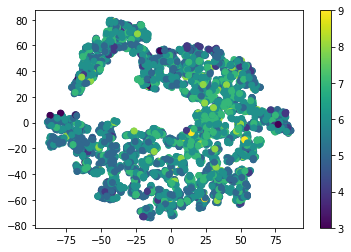

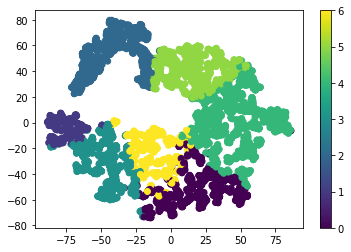

In [8]:
plt.scatter(embed_q[:, 0], embed_q[:, 1], c=(y_train_q))
plt.colorbar()
plt.show()

DAC = DeterministicAnnealingClustering(n_clusters=len(np.unique(y_train_q)), random_state=42)
DAC.fit(X_train_q)
clu = np.argmax(DAC.cluster_probabs_, axis=1)
plt.figure()
plt.scatter(embed_q[:, 0], embed_q[:, 1], c=clu)
plt.colorbar()
plt.show()

<h2 style="background-color:#4286f4;"> Comments </h2>

Let us know what you liked about this exercise, and what we can improve!